# Pedestrian Footfall Dataset Exploratory Analysis

Dataset: https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-2009-to-Present-counts-/b2ak-trbp

Note: you will need the Jupyer Lab plotly extension installed: https://plotly.com/python/getting-started

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from datetime import datetime
from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

from utils import load_and_clean_pedestrian_data

pd.options.plotting.backend = "plotly"
data_path = Path("../data/Pedestrian_Counting_System___2009_to_Present__counts_per_hour_.csv")

In [2]:
foot_df = load_and_clean_pedestrian_data(data_path)
foot_df.head()

ID               Date_Time  Year     Month  Mdate     Day  Time  \
0  2887628  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
1  2887629  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
2  2887630  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
3  2887631  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
4  2887632  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   

   Sensor_ID                   Sensor_Name  Hourly_Counts            datetime  \
0         34          Flinders St-Spark La            300 2019-11-01 17:00:00   
1         39                  Alfred Place            604 2019-11-01 17:00:00   
2         37               Lygon St (East)            216 2019-11-01 17:00:00   
3         40  Lonsdale St-Spring St (West)            627 2019-11-01 17:00:00   
4         36               Queen St (West)            774 2019-11-01 17:00:00   

   datetime_flat_year  
0 2000-11-01 17:00:00  
1 2000-11-01 17:00:00  
2 2000-11-01 17:00:00  
3 2000-11-01 17:00:00  
4 2000-11-01 17:00:00

_Q: How many years does the data set cover?_

In [3]:
sorted(foot_df["Year"].unique())

[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

_Q: How many sensors are in the dataset?

In [4]:
len(foot_df["Sensor_Name"].unique())

69

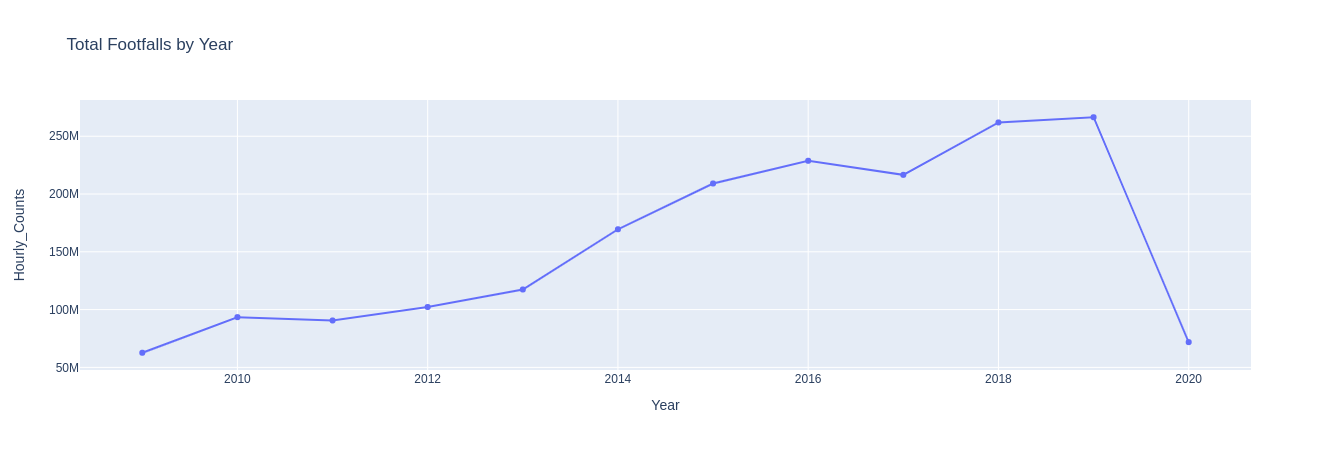

In [6]:
year_counts_df = foot_df.groupby("Year")["Hourly_Counts"].sum().reset_index()
px.line(year_counts_df, x="Year", y="Hourly_Counts", title="Total Footfalls by Year").update_traces(mode='lines+markers')

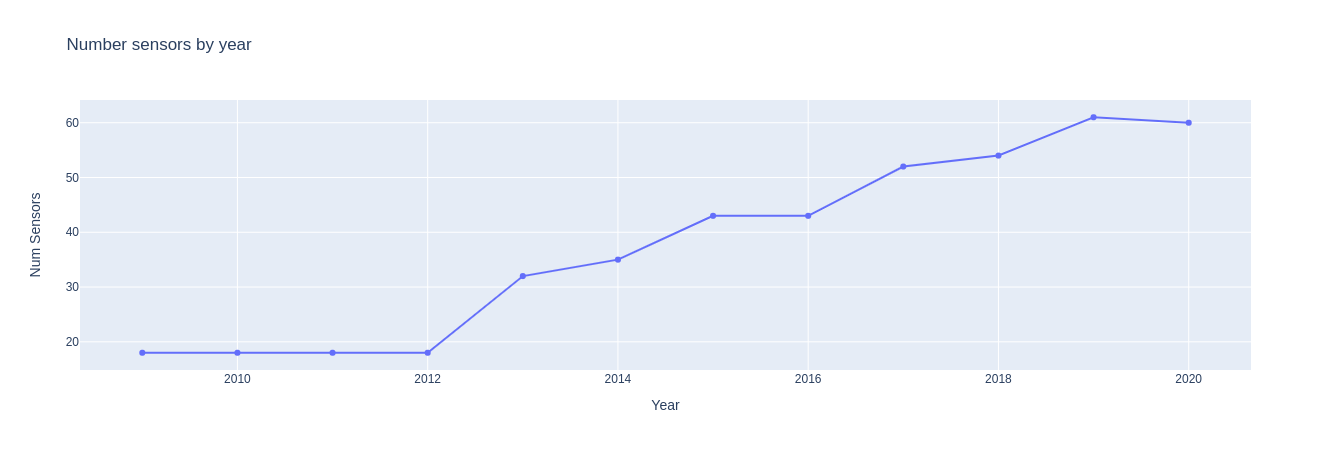

In [7]:
num_sensors_df = foot_df.groupby("Year")["Sensor_Name"].nunique().reset_index(name="Num Sensors")
px.line(num_sensors_df, x="Year", y="Num Sensors", title="Number sensors by year").update_traces(mode='lines+markers')

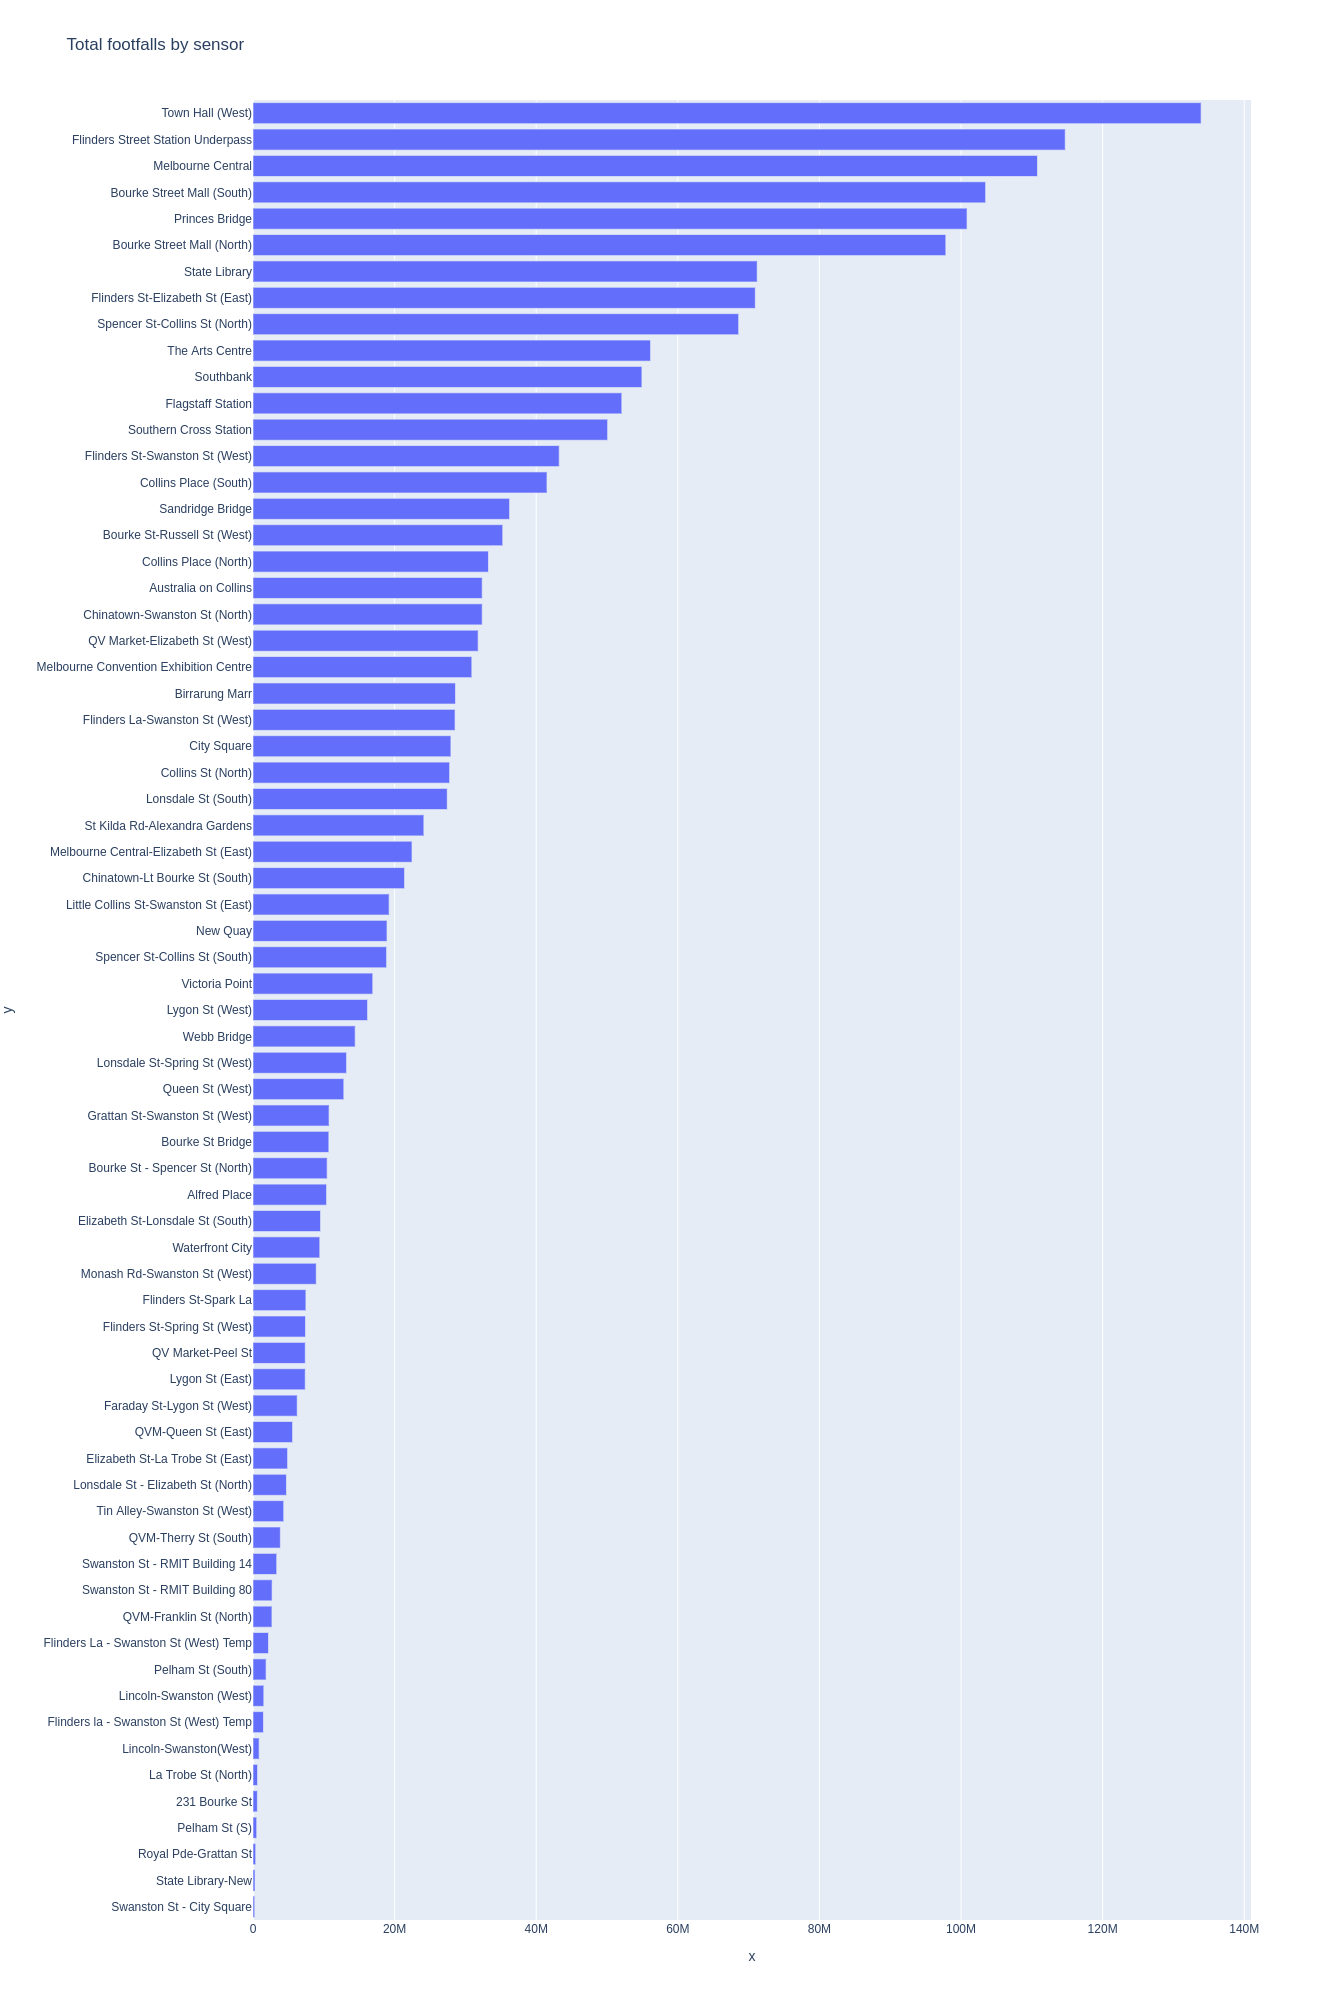

In [8]:
def plot_by_sensor(df, year=None):
    """Make a bar chart for total footfals for each sensor"""
    title = "Total footfalls by sensor"
    if year is not None:
        df = df[df["Year"] == year]
        title = title + f" for {year}"
    total = df.groupby("Sensor_Name")["Hourly_Counts"].sum().sort_values()
    return px.bar(y=total.index, x=total, title=title, orientation='h', height=2000, width=1000)

plot_by_sensor(foot_df)

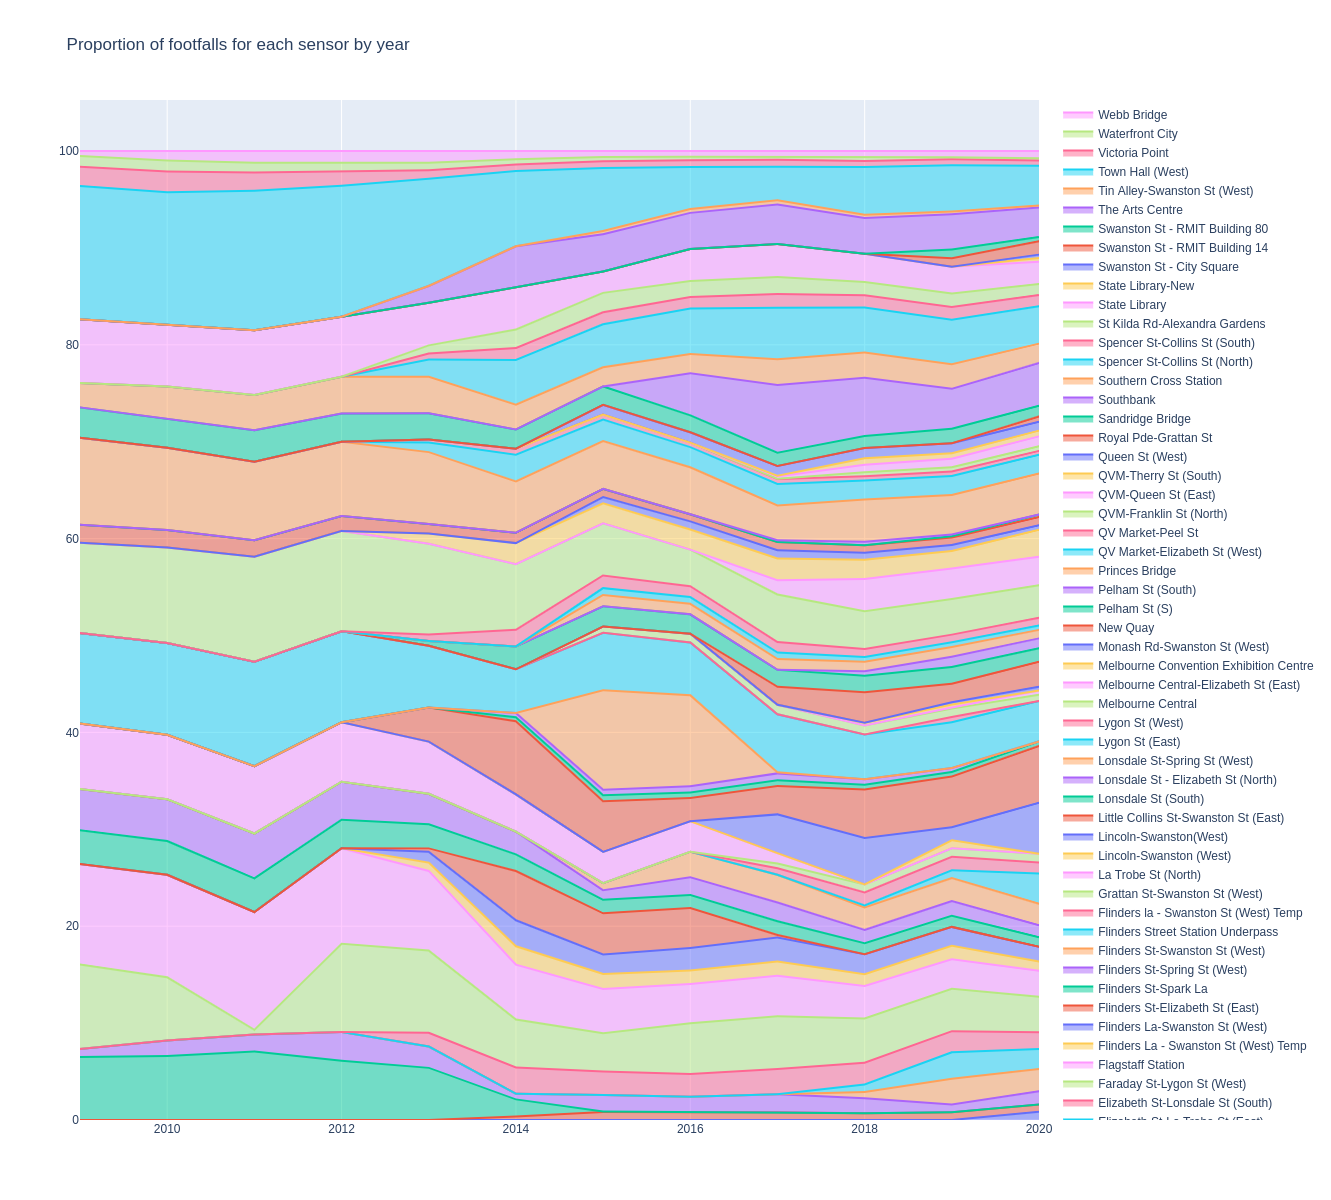

In [9]:
# maybe when a subset of sensors are viewed, it should be a line chart
# otherwise, using the stacked chart gives the false impression that the currently selected
# sensors are all the traffic

# other problem with stacked area chart is that it makes the sensors that come online
# at a specific year look like they have readings during the year before, but the values are discrete obviously

# another problem is not being able to hover over all traces

def make_stacked_sensor_plot(df, years=None, sensors=None, normalised=True):
    if years is not None:
        df = df[df["Year"].isin(years)]
    if sensors is not None:
        df = df[df["Sensor_Name"].isin(sensors)]
    sensor_years_s = df.groupby(["Sensor_Name", "Year"])["Hourly_Counts"].sum()
    sensor_dfs = [(sensor, dfx.reset_index("Sensor_Name")) for sensor, dfx in sensor_years_s.groupby(level=0)]

    fig = go.Figure()
    for sensor, df in sensor_dfs:   
        fig.add_trace(go.Scatter(
            x=df.index, y=df["Hourly_Counts"],
            #mode='lines',
            name=sensor,
            stackgroup='one',
            groupnorm='percent' if normalised else "",
        ))

    fig.update_layout(width=1500, height=1200, title="Proportion of footfalls for each sensor by year")
    return fig

make_stacked_sensor_plot(foot_df)

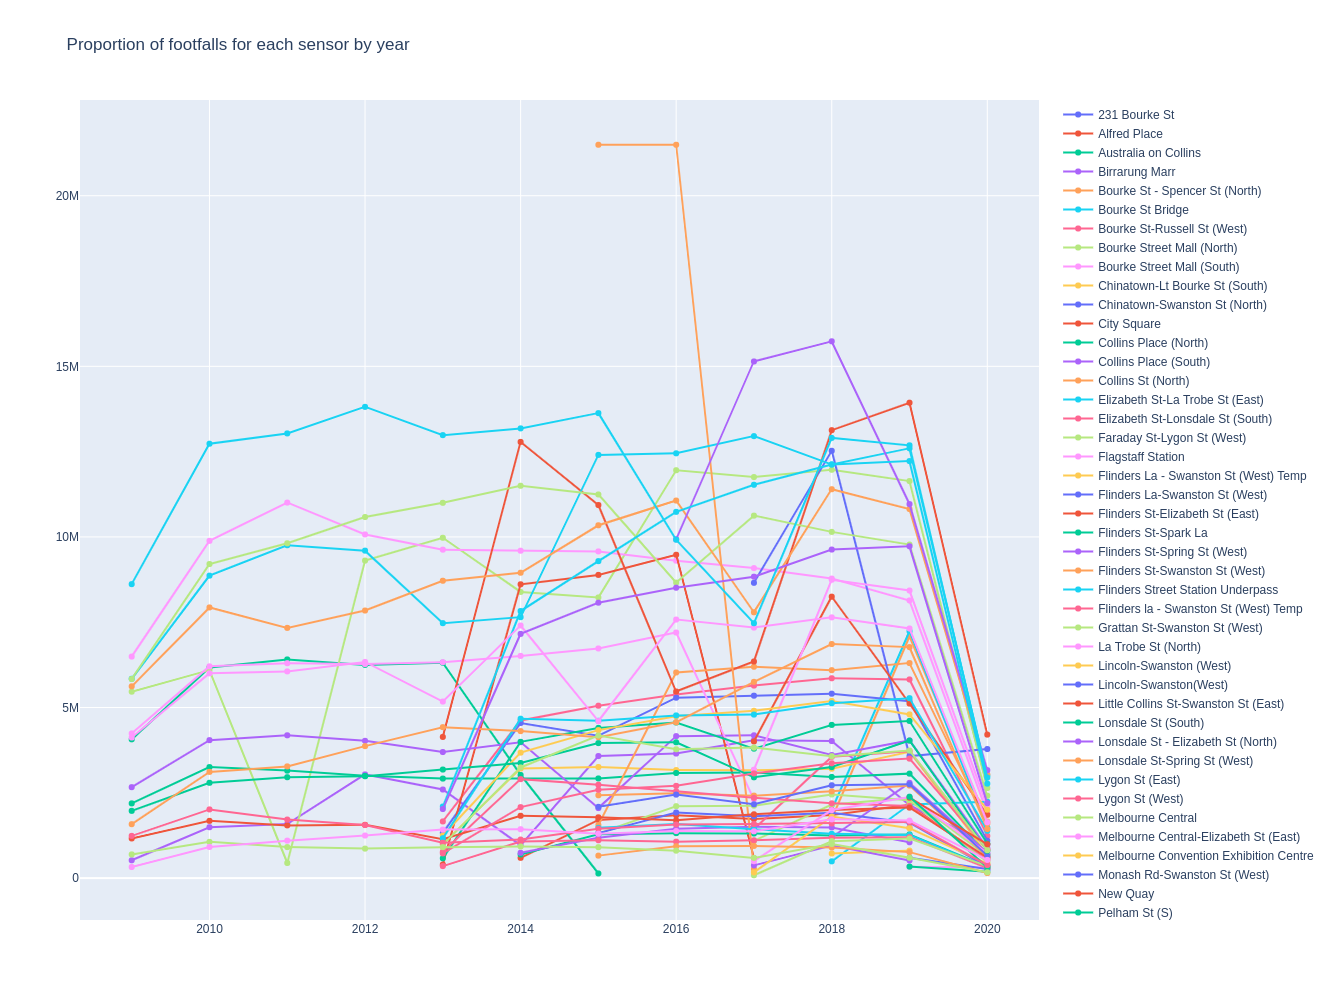

In [15]:
# maybe when a subset of sensors are viewed, it should be a line chart
# otherwise, using the stacked chart gives the false impression that the currently selected
# sensors are all the traffic

# other problem with stacked area chart is that it makes the sensors that come online
# at a specific year look like they have readings during the year before, but the values are discrete obviously

# another problem is not being able to hover over all traces

def make_line_plot(df, years=None, sensors=None, normalised=True):
    if years is not None:
        df = df[df["Year"].isin(years)]
    if sensors is not None:
        df = df[df["Sensor_Name"].isin(sensors)]
    sensor_years_s = df.groupby(["Sensor_Name", "Year"])["Hourly_Counts"].sum()
    sensor_dfs = [(sensor, dfx.reset_index("Sensor_Name")) for sensor, dfx in sensor_years_s.groupby(level=0)]

    fig = go.Figure()
    for sensor, df in sensor_dfs:   
        fig.add_trace(go.Scatter(
            mode="lines+markers",
            x=df.index, y=df["Hourly_Counts"],
            name=sensor,
            hovertemplate = "%{y:,}",
            # don't truncate the hover text
            hoverlabel={"namelength":-1},
            #line=go.scatter.Line(color="gray"),
        ))

    fig.update_layout(clickmode="event+select", width=1500, height=1000, title="Proportion of footfalls for each sensor by year")
    #fig.update_yaxes(hoverformat=".2")
    return fig

make_line_plot(data_df)

In [16]:
year_df = data_df[data_df["Year"] == 2009]
sensors = year_df.groupby("Sensor_Name")["Hourly_Counts"].sum()
series = sensors.sort_values(ascending=False).cumsum()/sensors.sum()